In [11]:
import numpy as np
import harmonica as hm
import verde as vd
import matplotlib.pyplot as plt
import xrft
import warnings

In [12]:
warnings.filterwarnings('ignore')

In [13]:
def plain_coordinates(spacing):
    '''
    Define as coordenadas do aerolevantamento. 
    _____________________________
    Recebe
    ----------
    spacing (espaçamento entre as linhas de voo)
    _____________________________
    Retorna 
    ----------
    as coordenadas do levantamento.
    _____________________________
    ''' 
    # Definindo parâmetros do levantamento
    northing = 90e3 # limite ao norte
    easting = 100e3 # limite ao leste
    region = [0, easting, 0, northing]
    # voos sentido norte
    # altitude de voo: 500m
    spacing_1 = (500,spacing) 
    coordinates_1 = vd.grid_coordinates(region=region, spacing=spacing_1, extra_coords=500) 
    # voos sentido leste
    # altitude de voo: 500m
    spacing_2 = (20000,500) 
    coordinates_2 = vd.grid_coordinates(region=region, spacing=spacing_2, extra_coords=500) 

    # Criando polinômios que simulam a variação da altitude de voo 
    x1 = np.linspace(0,northing,len(coordinates_1[2]))
    polinomio_1 = 10*np.sin(0.1*x1)+np.cos(0.1*x1)
    
    for i in range(len(coordinates_1[2][0])):
        for j in range (len(coordinates_1[2])):
            coordinates_1[2][j][i] += polinomio_1[j]
    
    x2 = np.linspace(0,easting,len(coordinates_2[2][0]))
    polinomio_2 = 10*np.sin(0.1*x2)+np.cos(0.1*x2)
    for i in range(len(coordinates_2[2])):
        for j in range (len(coordinates_2[2][0])):
            coordinates_2[2][i][j] += polinomio_2[j]

    
    # Concatenando coordinates_1 e coordinates_2 
    coordinates_1_2 = []
    for i in range(0,3):
        coordinates_1_2.append(np.concatenate((np.ravel(coordinates_1[i]),np.ravel(coordinates_2[i]))))
    
    # Adicionando ruído nas coordenadas do levantamento 
    noise_level_coords = 150
    
    coordinates = [ 
        coordinates_1_2[0] + np.random.normal(0, noise_level_coords, size=coordinates_1_2[i].shape),
        coordinates_1_2[1] + np.random.normal(0, noise_level_coords, size=coordinates_1_2[i].shape),
        coordinates_1_2[2],
    ]


    return (coordinates)

def magnetic(coordinates):
    '''
    Função que define as fontes magnéticas.

    Parameters
    ---------------
    coordinates: coordenadas do levantamento 

    Returns
    --------------
    magnetic_anomaly: campo magnético gerado pelas fontes
    '''
    inclination, declination = -20, -15
    base_level = 500
    noise_level = 200
    main_field = hm.magnetic_angles_to_vec(1, inclination, declination)
    magnetic_anomaly = 0
    
    # Dipoles
    dipole_coordinates = (60e3, 60e3, -1.5e3)
    magnetic_field = hm.dipole_magnetic(
        coordinates,
        dipoles=dipole_coordinates,
        magnetic_moments=hm.magnetic_angles_to_vec(3.5e11, inclination, declination),
        field="b",
    )
    magnetic_anomaly = sum(b * f for b, f in zip(magnetic_field, main_field))
    
    dipole2_coordinates = (20e3, 80e3, -2e3)
    magnetic_field = hm.dipole_magnetic(
        coordinates,
        dipoles=dipole2_coordinates,
        magnetic_moments=hm.magnetic_angles_to_vec(2.5e11, inclination, declination),
        field="b",
    )
    magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))
    
    # Pipe
    size = 90
    pipe_coordinates = (60e3, 80e3, -2e3)
    magnetic_field = hm.prism_magnetic(
        coordinates,
        prisms=[
            pipe_coordinates[0] - size,
            pipe_coordinates[0] + size,
            pipe_coordinates[1] - size,
            pipe_coordinates[1] + size,
            pipe_coordinates[2] - 10e3,
            pipe_coordinates[2],
        ],
        magnetization=hm.magnetic_angles_to_vec(5.5e3, -90, 0),
        field="b",
    )
    magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))
    
    # Dike
    dike_coordinates = (30e3, 30e3, 0)
    magnetic_field = hm.prism_magnetic(
        coordinates,
        prisms=[
            dike_coordinates[0] - 100e3,
            dike_coordinates[0] + 100e3,
            dike_coordinates[1] - 1000,
            dike_coordinates[1] + 1000,
            dike_coordinates[2] - 100,
            dike_coordinates[2],
        ],
        magnetization=hm.magnetic_angles_to_vec(150, inclination, declination),
        field="b",
    )
    magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))
    
    # Line
    line_coordinates = [30e3, 50e3, -1.5e3]
    magnetic_field = hm.prism_magnetic(
        coordinates,
        prisms=[
            line_coordinates[0] - 50,
            line_coordinates[0] + 50,
            line_coordinates[1],
            line_coordinates[1] + 100e3,
            line_coordinates[2] - 500,
            line_coordinates[2] + 500,
        ],
        magnetization=hm.magnetic_angles_to_vec(2.5e3, inclination, declination),
        field="b",
    )
    magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))
    
    # Sill
    sill_coordinates = [80e3, 25e3, -0.5e3]
    magnetic_field = hm.prism_magnetic(
        coordinates,
        prisms=[
            sill_coordinates[0] - 10e3,
            sill_coordinates[0] + 10e3,
            sill_coordinates[1] - 15e3,
            sill_coordinates[1] + 15e3,
            sill_coordinates[2] - 100,
            sill_coordinates[2] + 100,
        ],
        magnetization=hm.magnetic_angles_to_vec(100, inclination, declination),
        field="b",
    )
    magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))
    
    # Regional
    magnetic_anomaly += 0.006 * coordinates[0] - 0.007 * coordinates[1]
    
    # Add noise and the base level
    magnetic_anomaly += np.random.default_rng(42).normal(
        0, noise_level, size=magnetic_anomaly.shape
    )
    magnetic_anomaly += base_level
    
    return(magnetic_anomaly)


# Variando espaçamento entre as linhas de voo

In [14]:
coords = []
magnetic_anomalys= []
grids_eq = []
residuos = []
R_2_true = []
R_2_random = []
R_2_blocks = []

In [15]:
#48minutos
spacings = [500, 2000, 4000]

# Regular grid
region = [0, 100e3, 0, 90e3]
coordinates_grid = vd.grid_coordinates(region, spacing=1e3, extra_coords=500)
magnetic_anomaly_grid = magnetic(coordinates_grid)
grid_true = vd.make_xarray_grid(
    coordinates_grid[:2], (magnetic_anomaly_grid, coordinates_grid[-1]), data_names=["field", "height"]
)

for spacing in spacings:
    coordinates = plain_coordinates(spacing)
    coords.append(coordinates)
    magnetic_anomaly = magnetic(coordinates)
    magnetic_anomalys.append(magnetic_anomaly)
    
    # Equivalent sources
    fonts = hm.EquivalentSourcesGB(damping=1,depth=1e3)
    fonts.fit([coordinates[0],coordinates[1],coordinates[2]],data=magnetic_anomaly)
    grid_coords_eq = vd.grid_coordinates(region,spacing=1e3,extra_coords=500)
    grid_eq = fonts.grid(grid_coords_eq,data_names="field")
    grids_eq.append(grid_eq)
    
    # Residuo
    residuo = grid_true - grid_eq
    residuos.append(residuo)
    
    # R_2 true 
    media = np.sum(grid_eq.field.values)/np.size(grid_eq.field)
    residuo_2 = np.sum(residuo.field.values**2)
    R_2_true.append(1 - (residuo_2/np.sum((grid_eq.field.values- media)**2)))
    
    # R_2 cv without blocks
    R_2_random.append(np.mean(vd.cross_val_score(fonts,coordinates,magnetic_anomaly)))

    # R_2 cv with blocks
    blocks = np.linspace(500,5000,5)
    nsplits = 5
    R_2_block = [] 
    
    for block in blocks:
        R_2_block.append(np.mean(
            vd.cross_val_score(
                fonts,
                coordinates,
                magnetic_anomaly,
                cv=vd.BlockKFold(spacing=block, n_splits=nsplits, shuffle=True, random_state=123),
            )
        ))

    R_2_blocks.append(R_2_block)

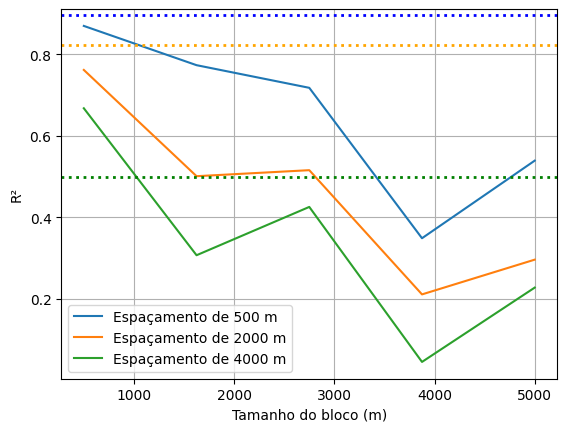

In [16]:
plt.plot(blocks,R_2_blocks[0],label=f"Espaçamento de {spacings[0]} m")
plt.plot(blocks,R_2_blocks[1],label=f"Espaçamento de {spacings[1]} m")
plt.plot(blocks,R_2_blocks[2],label=f"Espaçamento de {spacings[2]} m")
plt.xlabel("Tamanho do bloco (m)")
plt.ylabel("R²")

#plt.axhline(y = R_2_true[i], color = 'green', linestyle='--', label="R² true") 
#plt.axhline(y = R_2_random[i], color = 'green', linestyle='dotted', label="R² random") 
for i, color in zip([0,1,2],['blue', 'orange','green']):
    plt.axhline(y = R_2_true[i], color = color, linestyle='dotted', linewidth=2) 
plt.legend()
plt.grid(True)
# for i, color in zip([0,1,2],['blue','orange','green']):
#     #plt.axhline(y = R_2_true[i], color = color, label=f"R² true - {spacings[i]}") 
#     #plt.axhline(y = R_2_random[i], color = color, linestyle = 'dotted', label=f"R² random - {spacings[i]}") 
#     plt.axhline(y = R_2_true[i], color = color) 
#     plt.axhline(y = R_2_random[i], color = color, linestyle = 'dotted') 


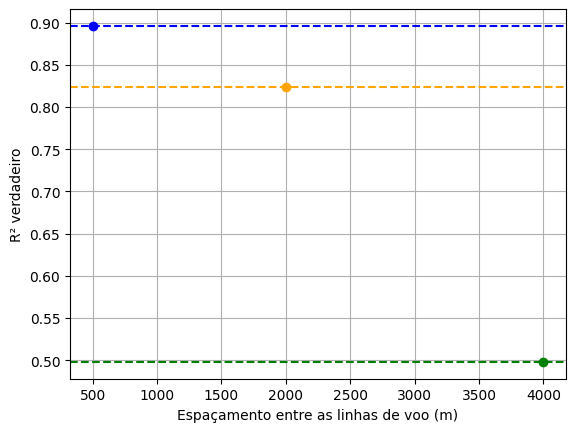

In [17]:
for i, color in zip([0,1,2], ['blue', 'orange','green']):
    plt.plot(spacings[i], R_2_true[i],"o",color=color)
    plt.axhline(y = R_2_true[i], color = color, linestyle='--', label="R² true") 
    plt.xlabel("Espaçamento entre as linhas de voo (m)")
    plt.ylabel("R² verdadeiro")
    plt.grid(True)

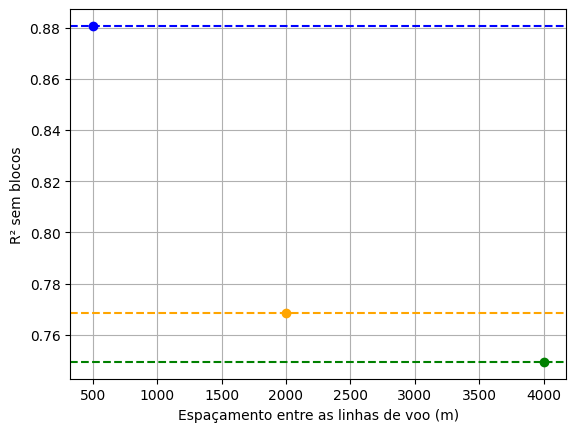

In [18]:
for i, color in zip([0,1,2], ['blue', 'orange','green']):
    plt.plot(spacings[i], R_2_random[i],"o",color=color)
    plt.axhline(y = R_2_random[i], color = color, linestyle='--', label="R² true") 
    plt.xlabel("Espaçamento entre as linhas de voo (m)")
    plt.ylabel("R² sem blocos")
    plt.grid(True)

In [19]:
# Regular grid
region = [0, 100e3, 0, 90e3]
coordinates_grid = vd.grid_coordinates(region, spacing=1e3, extra_coords=500)
magnetic_anomaly_grid = magnetic(coordinates_grid)
grid_true = vd.make_xarray_grid(
    coordinates_grid[:2], (magnetic_anomaly_grid, coordinates_grid[-1]), data_names=["field", "height"]
)

coordinates = plain_coordinates(5000)
coords.append(coordinates)
magnetic_anomaly = magnetic(coordinates)
magnetic_anomalys.append(magnetic_anomaly)

# Equivalent sources
fonts = hm.EquivalentSourcesGB(damping=1,depth=1e3)
fonts.fit([coordinates[0],coordinates[1],coordinates[2]],data=magnetic_anomaly)
grid_coords_eq = vd.grid_coordinates(region,spacing=1e3,extra_coords=500)
grid_eq = fonts.grid(grid_coords_eq,data_names="field")
grids_eq.append(grid_eq)

# Residuo
residuo = grid_true - grid_eq
residuos.append(residuo)

# R_2 true 
media = np.sum(grid_eq.field.values)/np.size(grid_eq.field)
residuo_2 = np.sum(residuo.field.values**2)
R_2_true.append(1 - (residuo_2/np.sum((grid_eq.field.values- media)**2)))

# R_2 cv without blocks
R_2_random.append(np.mean(vd.cross_val_score(fonts,coordinates,magnetic_anomaly)))

# R_2 cv with blocks
blocks = np.linspace(500,5000,5)
nsplits = 5
R_2_block = [] 

for block in blocks:
    R_2_block.append(np.mean(
        vd.cross_val_score(
            fonts,
            coordinates,
            magnetic_anomaly,
            cv=vd.BlockKFold(spacing=block, n_splits=nsplits, shuffle=True, random_state=123),
        )
    ))

R_2_blocks.append(R_2_block)

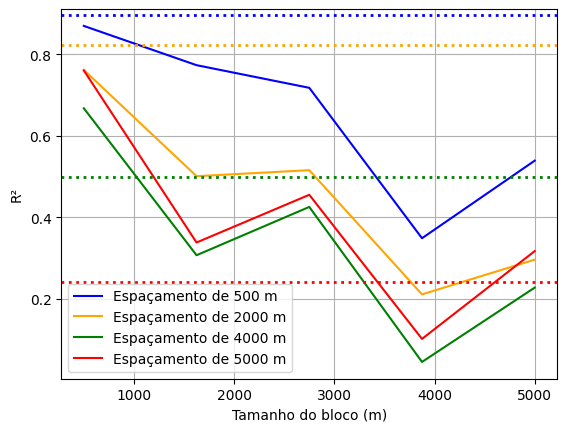

In [20]:
plt.plot(blocks,R_2_blocks[0],label=f"Espaçamento de {spacings[0]} m", color='blue')
plt.plot(blocks,R_2_blocks[1],label=f"Espaçamento de {spacings[1]} m", color='orange')
plt.plot(blocks,R_2_blocks[2],label=f"Espaçamento de {spacings[2]} m", color='green')
plt.plot(blocks,R_2_blocks[3],label=f"Espaçamento de 5000 m", color='red')
plt.xlabel("Tamanho do bloco (m)")
plt.ylabel("R²")

for i, color in zip([0,1,2,3],['blue', 'orange','green','red']):
    plt.axhline(y = R_2_true[i], color = color, linestyle='dotted', linewidth=2) 
plt.legend()
plt.grid(True)
plt.savefig('6.png', dpi=150)
